In [ ]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import os
import hashlib
import torch
import torch.nn as nn
import copy
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import AutoImageProcessor
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
# Check SHA1 hash to ensure file integrity
def check_sha1(filename, sha1_hash):
    sha1 = hashlib.sha1()
    with open(filename, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    return sha1.hexdigest()[:len(sha1_hash)] == sha1_hash

# Download the dataset from the URL
def download(url, path=None, overwrite=False, sha1_hash=None):
    if path is None:
        fname = url.split('/')[-1]
    else:
        fname = os.path.join(path, url.split('/')[-1]) if os.path.isdir(path) else path

    if overwrite or not os.path.exists(fname) or (sha1_hash and not check_sha1(fname, sha1_hash)):
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        print(f'Downloading {fname} from {url}...')
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(fname, 'wb') as f:
                for chunk in tqdm(r.iter_content(chunk_size=1024), unit='KB', dynamic_ncols=True):
                    f.write(chunk)
        if sha1_hash and not check_sha1(fname, sha1_hash):
            raise ValueError(f'File {fname} does not match hash {sha1_hash}')
    return fname

# Download ADE20K dataset
def download_ade(path, overwrite=False):
    if not os.path.exists(path):
        os.mkdir(path)
    _AUG_DOWNLOAD_URLS = [
        ('http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip', '219e1696abb36c8ba3a3afe7fb2f4b4606a897c7'),
    ]
    download_dir = os.path.join(path, 'downloads')
    os.makedirs(download_dir, exist_ok=True)
    for url, checksum in _AUG_DOWNLOAD_URLS:
        filename = download(url, path=download_dir, overwrite=overwrite, sha1_hash=checksum)
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(path=path)

# Dataset paths
root = "./"
dataset_path = os.path.join(root, "ADEChallengeData2016/images/")
training_data = "training/"
val_data = "validation/"

download_ade(root, overwrite=False)

N_CLASSES = 151
IMG_SIZE = 224

# Load image and mask paths
train_images = sorted(glob(os.path.join(dataset_path, training_data, "*.jpg")))
train_masks = sorted(glob(os.path.join(root, "ADEChallengeData2016/annotations/training/*.png")))
val_images = sorted(glob(os.path.join(dataset_path, val_data, "*.jpg")))
val_masks = sorted(glob(os.path.join(root, "ADEChallengeData2016/annotations/validation/*.png")))

# Dataset class
class ADE20KDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size=224):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.mask_transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x, dtype=np.int64))),
    ])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("P")
        image = self.image_transform(image)
        mask = self.mask_transform(mask).squeeze(0).long()
        return image, mask

# Segmentation model
class DINOv2Segmentation(torch.nn.Module):
    def __init__(self, base_model, num_classes, embed_dim=384):
        super(DINOv2Segmentation, self).__init__()
        self.base_model = base_model
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, num_classes, kernel_size=1),
        )

    def forward(self, x):
        features = self.base_model.get_intermediate_layers(x, n=1)[0]
        B, N, C = features.size()  # Batch size, Tokens, Channels
        H = W = int(N ** 0.5)  # Square spatial resolution
        features = features.permute(0, 2, 1).view(B, C, H, W)  # Reshape to (B, C, H, W)
        return self.decoder(features)

# Training setup
train_dataset = ADE20KDataset(train_images, train_masks, img_size=IMG_SIZE)
val_dataset = ADE20KDataset(val_images, val_masks, img_size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
model = DINOv2Segmentation(dinov2_vits14, N_CLASSES, embed_dim=384).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1
# Training loop with tqdm progress bar
for epoch in range(epochs):
    model.train()
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch+1}/10') as tepoch:
        for images, masks in tepoch:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)  # Shape: [B, N_CLASSES, H, W]

            # Upsample the outputs to match the size of the masks
            outputs_upsampled = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            # Compute the loss
            loss = criterion(outputs_upsampled, masks)
            loss.backward()
            optimizer.step()

            # Update tqdm description with loss information
            tepoch.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}/10, Loss: {loss.item()}")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Epoch 1/10: 100%|██████████| 1264/1264 [09:04<00:00,  2.32batch/s, loss=1.38]

Epoch 1/10, Loss: 1.3811290264129639


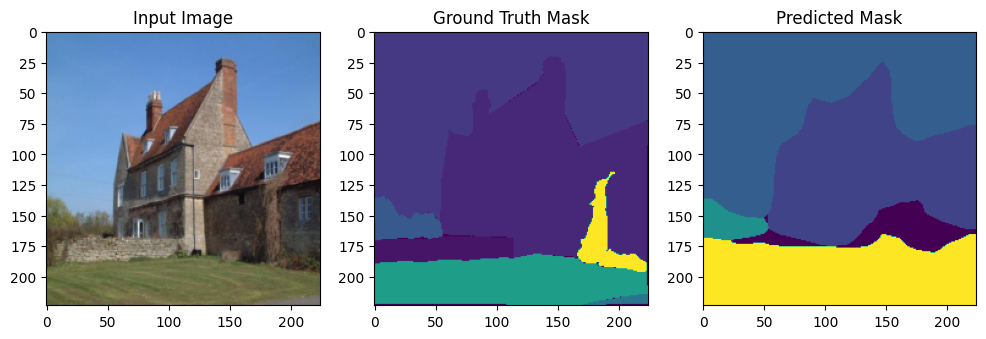

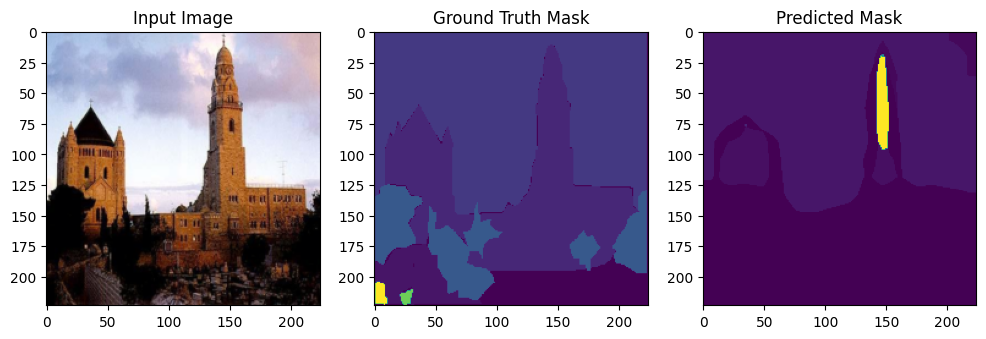

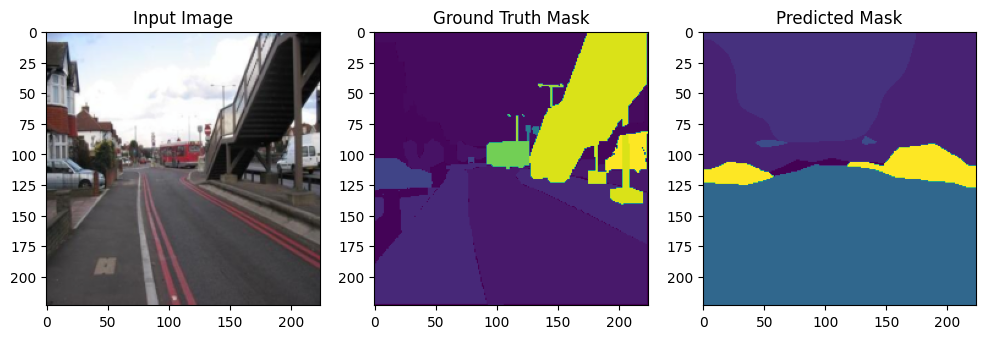

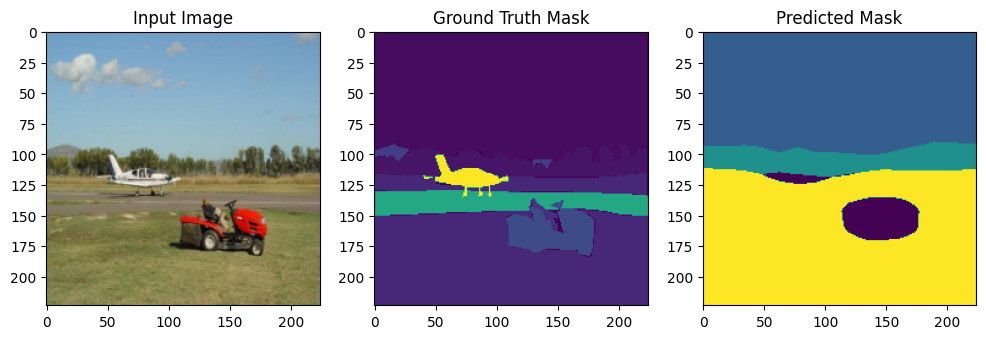

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Visualization function
def visualize_predictions(model, loader, device):
    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs_upsampled = F.interpolate(outputs, size=masks.shape[1:], mode="bilinear", align_corners=False)
        predictions = torch.argmax(outputs_upsampled, dim=1).cpu().numpy()

    # Visualize first batch
    for i in range(min(4, images.size(0))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize
        img = np.clip(img, 0, 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].cpu(), cmap="viridis")
        plt.title("Ground Truth Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap="viridis")
        plt.title("Predicted Mask")
        plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing:   0%|          | 0/125 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing:   1%|          | 1/125 [00:02<04:51,  2.35s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


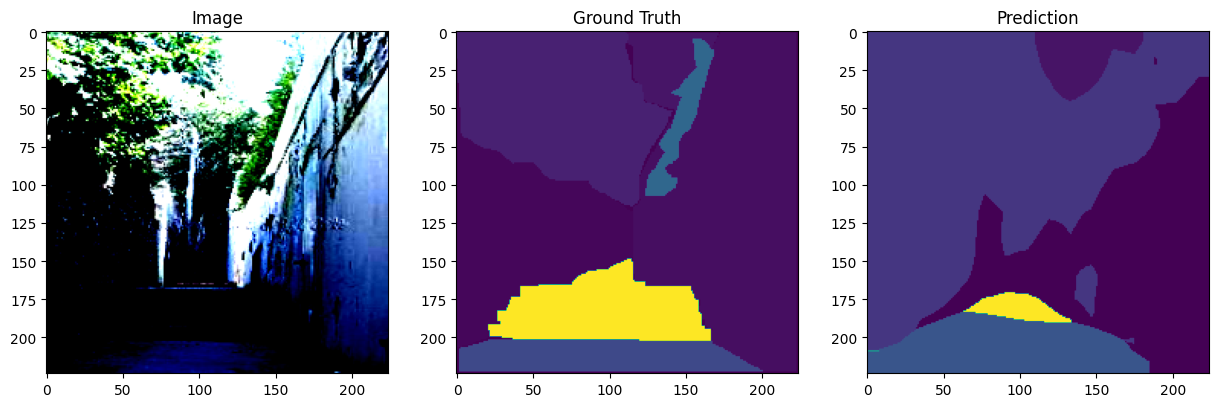

Testing:   2%|▏         | 2/125 [00:03<03:08,  1.53s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


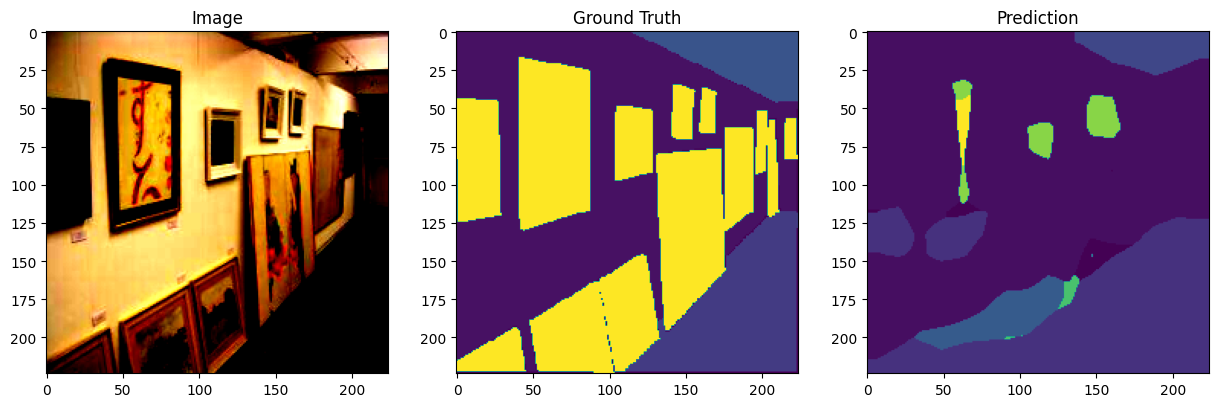

Testing:   2%|▏         | 3/125 [00:04<03:13,  1.59s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


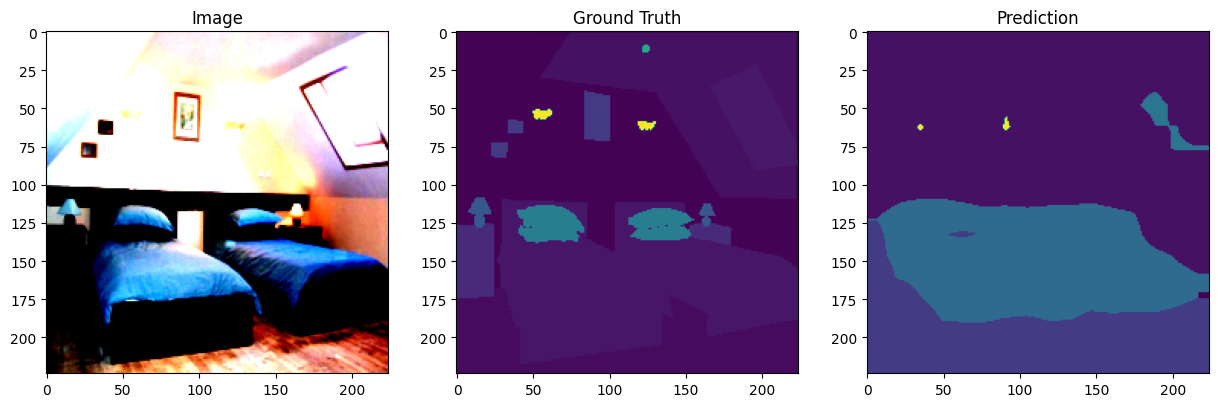

Testing:   3%|▎         | 4/125 [00:05<02:44,  1.36s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


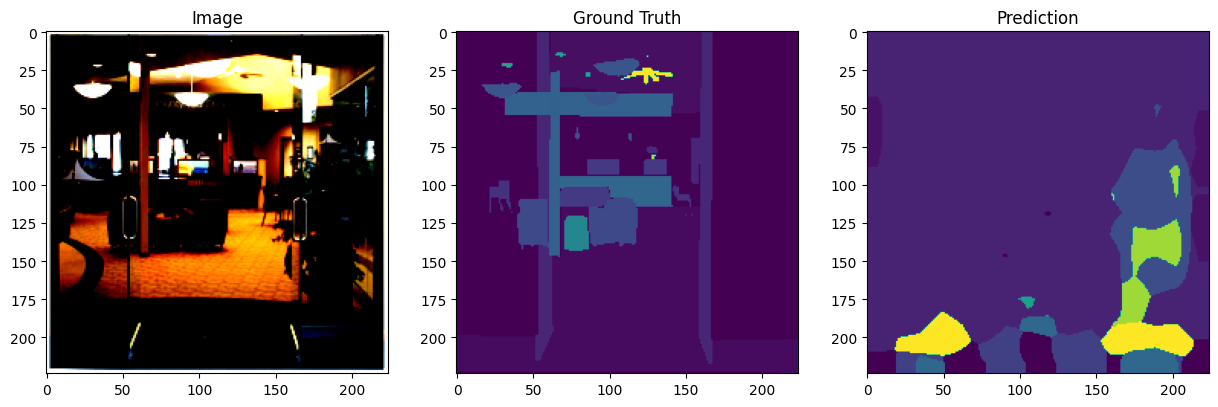

Testing:   4%|▍         | 5/125 [00:06<02:28,  1.24s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


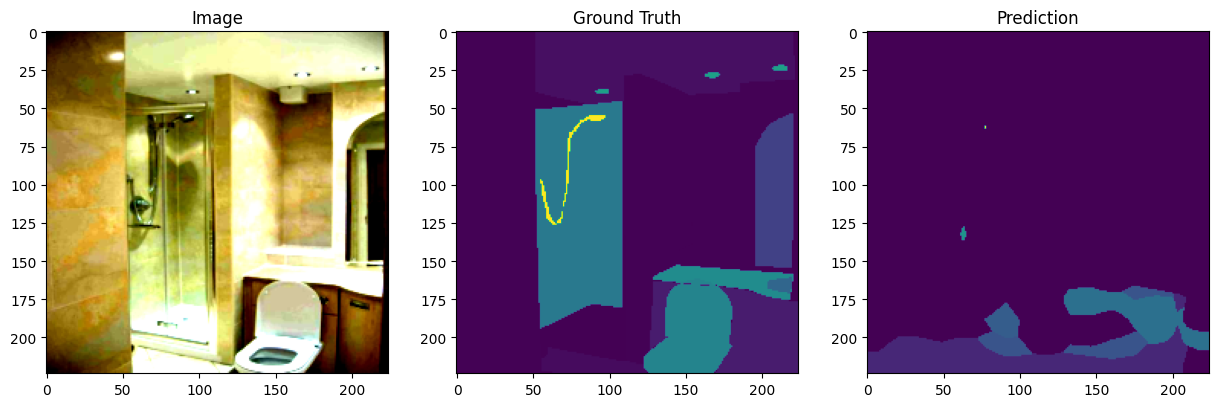

Testing:   5%|▍         | 6/125 [00:07<02:04,  1.05s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


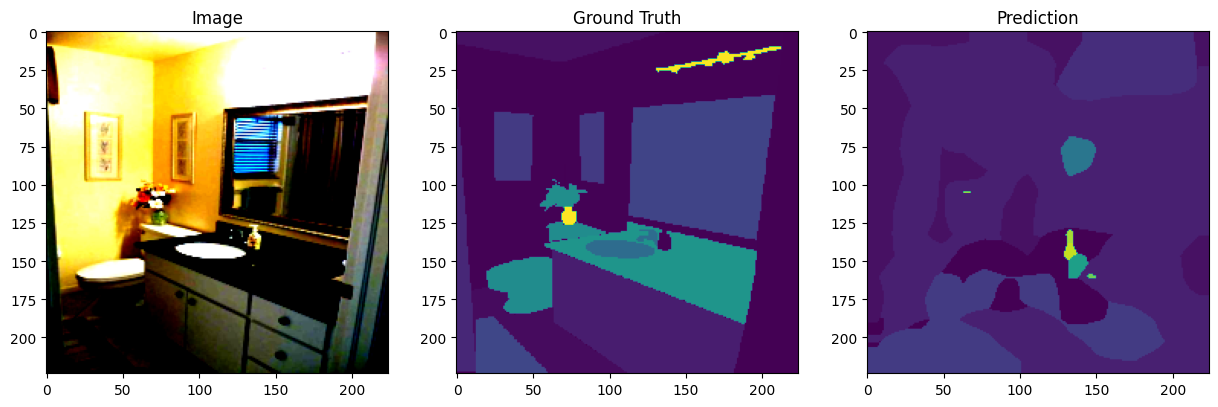

Testing:   6%|▌         | 7/125 [00:08<01:49,  1.08it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


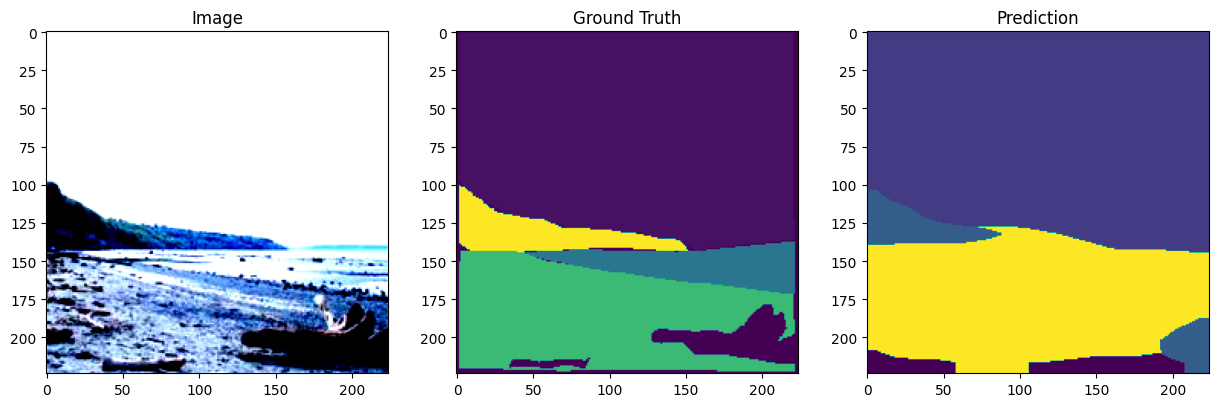

Testing:   6%|▋         | 8/125 [00:09<01:38,  1.19it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


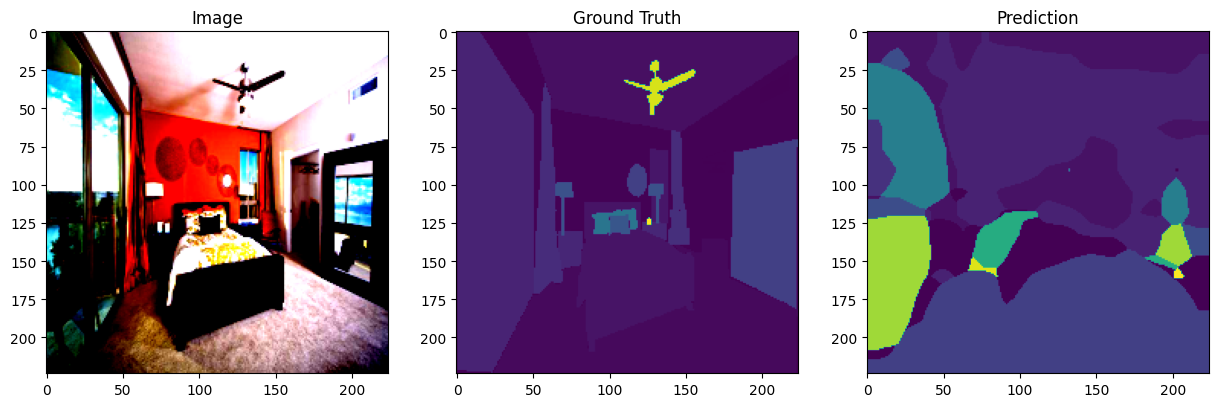

Testing:   7%|▋         | 9/125 [00:09<01:32,  1.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing:   8%|▊         | 10/125 [00:10<01:28,  1.30it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


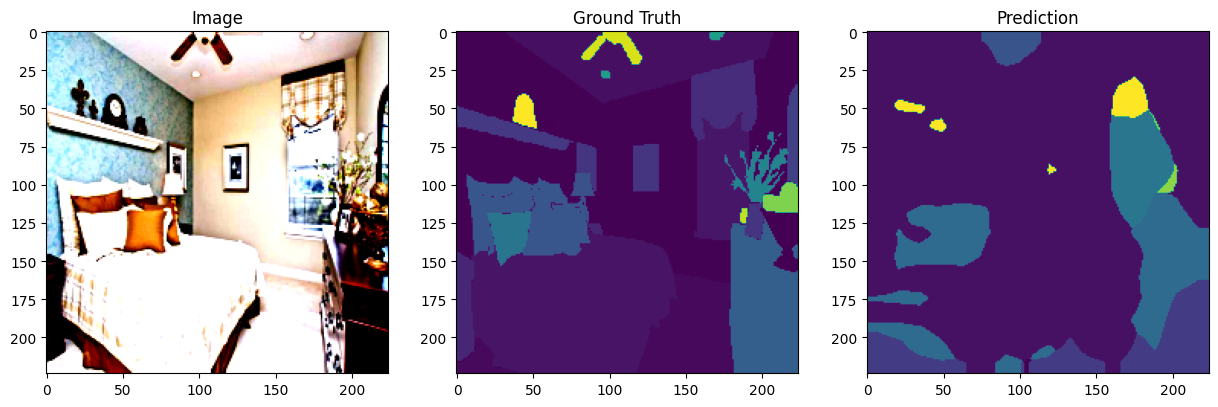

Testing:   9%|▉         | 11/125 [00:11<01:25,  1.33it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


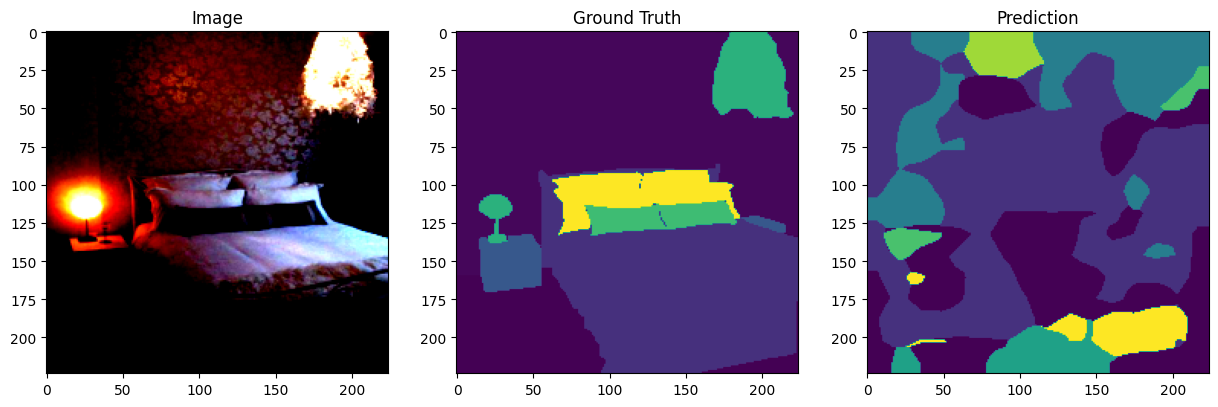

Testing:  10%|▉         | 12/125 [00:11<01:25,  1.32it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing:  10%|█         | 13/125 [00:12<01:23,  1.35it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


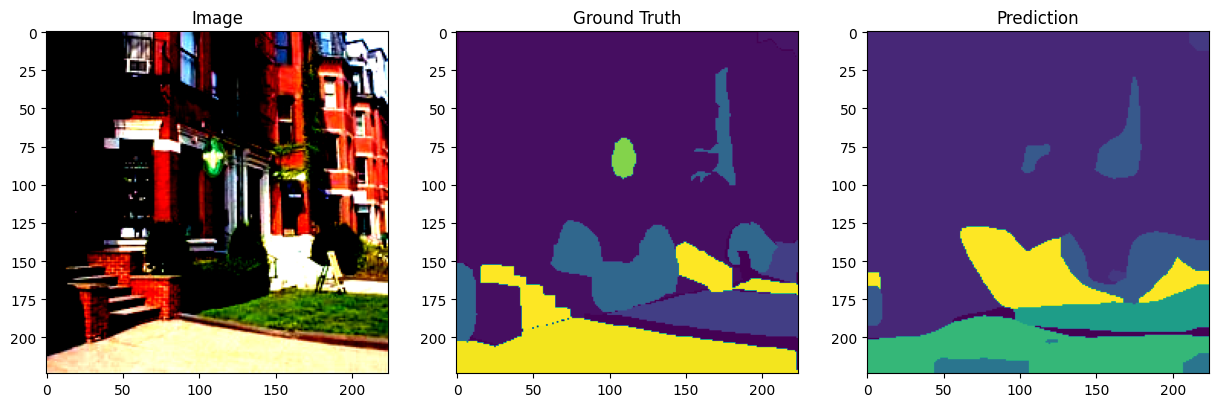

Testing:  11%|█         | 14/125 [00:13<01:20,  1.37it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing:  12%|█▏        | 15/125 [00:14<01:19,  1.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing:  13%|█▎        | 16/125 [00:14<01:19,  1.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


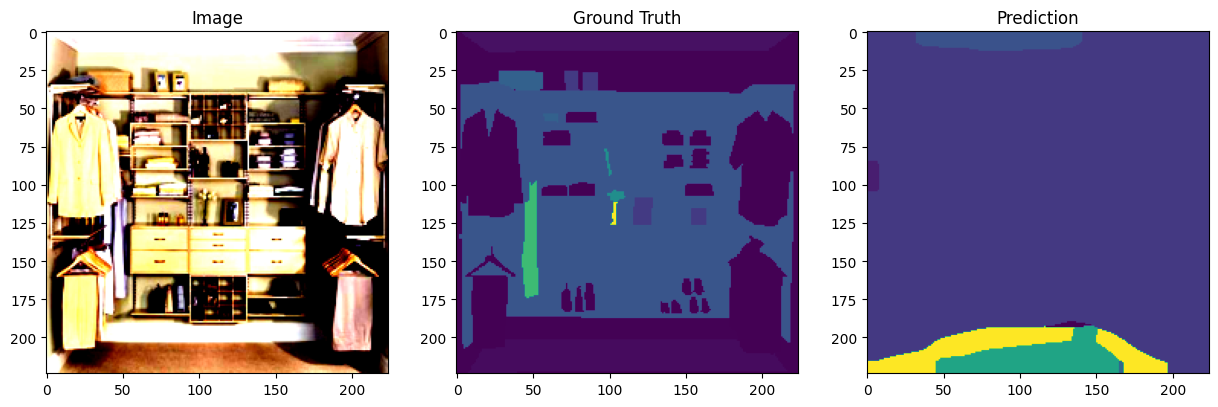

Testing:  14%|█▎        | 17/125 [00:15<01:22,  1.31it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


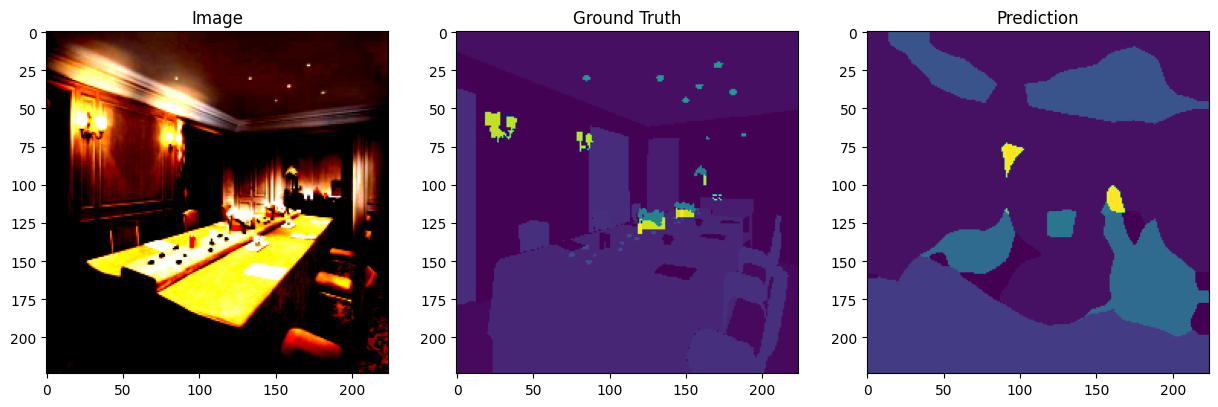

Testing:  14%|█▍        | 18/125 [00:16<01:19,  1.34it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


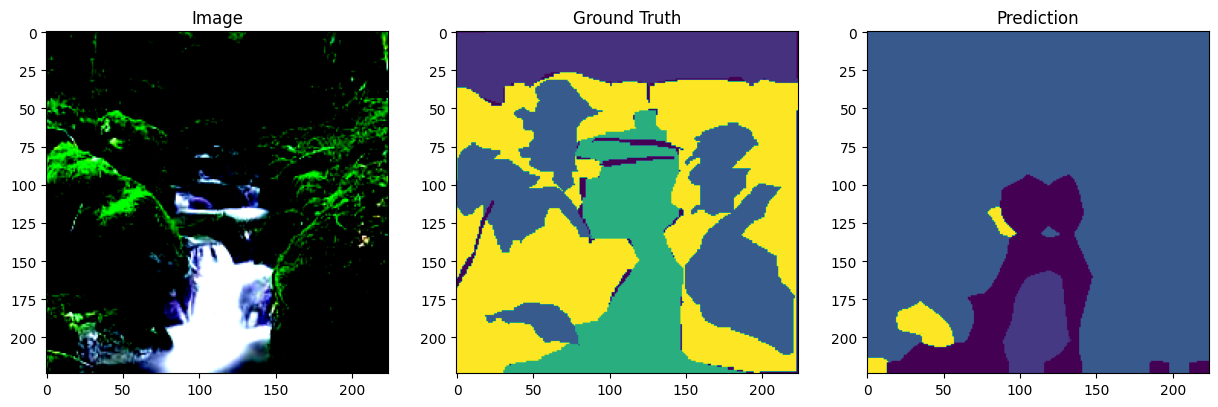

Testing:  15%|█▌        | 19/125 [00:17<01:18,  1.36it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


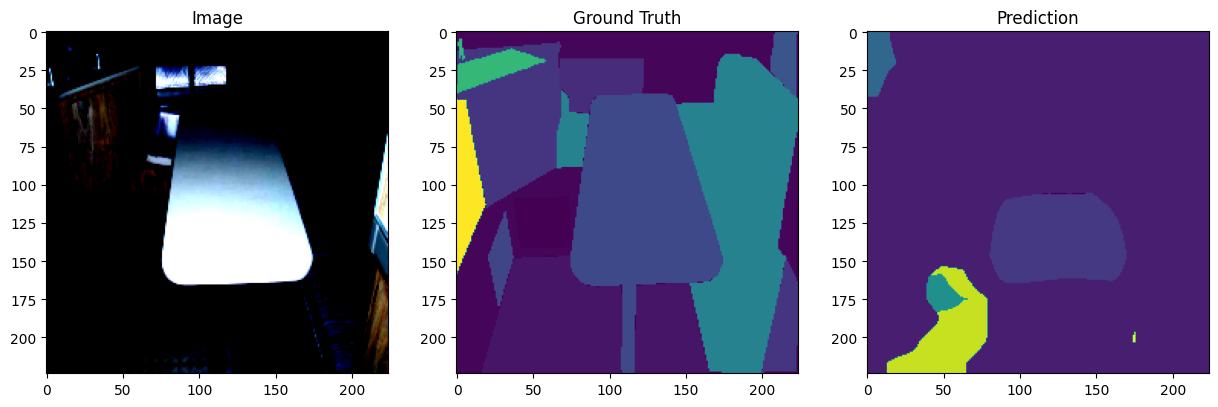

Testing:  16%|█▌        | 20/125 [00:18<01:39,  1.06it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


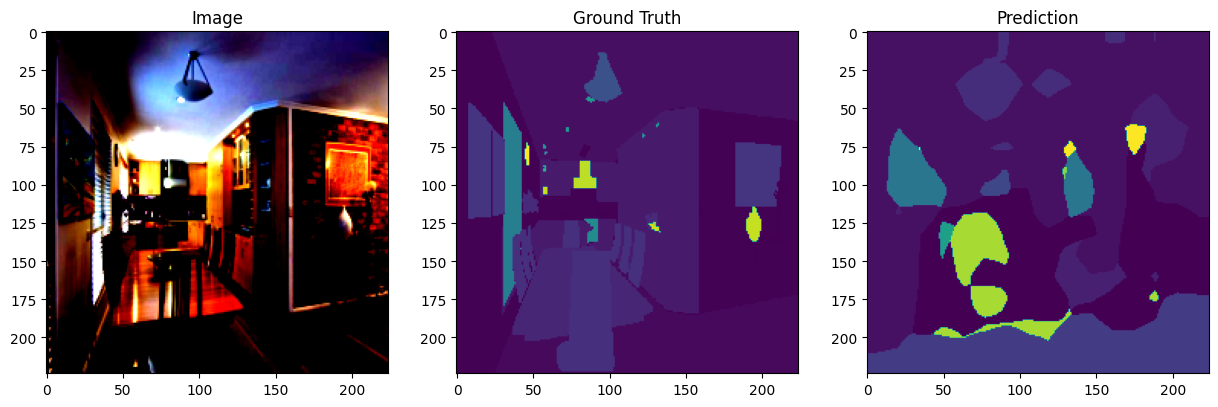

Testing:  17%|█▋        | 21/125 [00:20<01:41,  1.03it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to calculate IoU for each class
def compute_iou(pred, target, n_classes=N_CLASSES):
    iou_list = []
    for i in range(n_classes):
        # Create a binary mask for class i
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = torch.sum(pred_i * target_i)
        union = torch.sum(pred_i) + torch.sum(target_i) - intersection

        iou = intersection / union if union != 0 else torch.tensor(0.0)
        iou_list.append(iou)
    return iou_list

# Function to display images and masks
def visualize_predictions(images, masks, preds, idx=0):
    # Image
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Image")

    # Ground Truth
    axes[1].imshow(masks[idx].cpu().numpy())
    axes[1].set_title("Ground Truth")

    # Prediction
    axes[2].imshow(preds[idx].cpu().numpy())
    axes[2].set_title("Prediction")

    plt.show()

# Testing loop
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_iou = []  # To store IoU for each class across all batches

    # No gradient calculation needed during inference
    with torch.no_grad():
        # Loop through the test dataset
        for images, masks in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass: Get the outputs of the model
            outputs = model(images)  # Shape: [B, N_CLASSES, 16, 16]

            # Upsample the outputs to match the mask shape
            outputs_upsampled = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            # Get the predictions (class with highest probability)
            preds = torch.argmax(outputs_upsampled, dim=1)  # Shape: [B, H, W]

            # Compute IoU for each batch
            iou_list = compute_iou(preds, masks)
            all_iou.append(iou_list)

            # Optionally visualize the predictions for the first image
            visualize_predictions(images, masks, preds, idx=0)

    # Calculate average IoU across all batches
    avg_iou = np.mean(all_iou, axis=0)
    print(f"Average IoU per class: {avg_iou}")

    return avg_iou

test_dataset = ADE20KDataset(val_images, val_masks, img_size=IMG_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Run the test
avg_iou = test_model(model, test_loader)